# visalizations

> Visualizations to help understand what's going on

In [ ]:
#|default_exp visualization

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export

from isaacai.utils import *
from isaacai.dataloaders import *
from isaacai.models import *
from isaacai.initialization import *
from isaacai.trainer import *
from isaacai.training import *
from isaacai.recording import *

import fastcore.all as fc
from torch.optim.lr_scheduler import ExponentialLR
import math
from isaacai.utils import *
from isaacai.dataloaders import *
from isaacai.models import *
from isaacai.training import *
import torch.nn as nn
import torch
import matplotlib.pyplot as plt,matplotlib as mpl
from datasets import load_dataset, Dataset
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torcheval.metrics import MulticlassAccuracy
from IPython.display import clear_output
import dill as pickle

In [ ]:
#|hide
import logging

In [ ]:
#| hide
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
# mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
xmean,xstd = 0.28, 0.35
@inplace
def transformi(b): b['image'] = [(TF.to_tensor(o)-xmean)/xstd for o in b['image']]

_dataset = load_dataset('fashion_mnist').with_transform(transformi)
# _dataset = sample_dataset_dict(_dataset)
dls = DataLoaders.from_dataset_dict(_dataset, 256, num_workers=4)


  0%|          | 0/2 [00:00<?, ?it/s]

## Learning Rate Finder

In [ ]:
#| export
class LRFinderCB(Callback):
    order = 1
    def __init__(self,lr_mult=1.3): fc.store_attr()
    
    def before_fit(self,trainer):
        pickle.dump(trainer,open('_tmp.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)
        self.scheduler = ExponentialLR(optimizer=trainer.opt,gamma=self.lr_mult)
        self.lrs, self.losses = fc.L(), fc.L()
        self.min = math.inf
        
    def before_batch(self,trainer):
        if not trainer.training: raise CancelEpochException()
        
    def after_batch(self,trainer):
        loss = to_cpu(trainer.loss)
        if loss > self.min * 3: raise CancelEpochException()
        self.lrs.append(trainer.opt.param_groups[0]['lr'])
        self.losses.append(loss)        
        if loss < self.min: self.min = loss
        self.scheduler.step()
        
    def after_fit(self,_):
        plt.figure(figsize=(12,4))
        plt.plot(self.lrs,self.losses)
        plt.xscale('log')
        plt.title('Learning Rate Finder'); plt.xlabel('Learning Rate'); plt.ylabel('Losses') 
        plt.show()
        
    def cleanup_fit(self,trainer):
        _name = retrieve_global_name(trainer)
        globals()[_name[0]] = pickle.load(open('_tmp.pkl','rb'))

In [ ]:
trainer = Trainer(dls,
                  nn.CrossEntropyLoss(), 
                  torch.optim.SGD, 
                  get_model_fc(), 
                  callbacks=[BasicTrainCB(),DeviceCB(),MetricsCB(Accuracy=MulticlassAccuracy())])

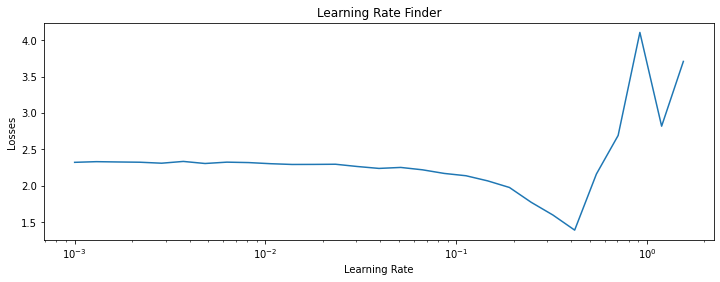

In [ ]:
trainer.fit(callbacks=[LRFinderCB()])

# Activation Stats

In [ ]:
#|export
class HooksCallback(Callback):
    def __init__(self, hookfunc, module_filter=fc.noop, on_train=True, on_valid=False, modules=None):
        fc.store_attr()
    
    def before_fit(self, trainer):
        if self.modules: modules=self.modules
        else: modules = fc.filter_ex(trainer.model.modules(), self.module_filter)
        self.hooks = Hooks(modules, fc.bind(self._hookfunc, trainer))

    def _hookfunc(self, trainer, *args, **kwargs):
        if (self.on_train and trainer.training) or (self.on_valid and not trainer.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, trainer): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [ ]:
#|export
def append_stats(hook, module, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

# Thanks to @ste for initial version of histgram plotting code
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

In [ ]:
#|export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

class ActivationStatsCB(HooksCallback):
    def __init__(self, module_filter=fc.noop): super().__init__(append_stats, module_filter)

    def color_dim(self, figsize=(11,6)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [ ]:
model = get_model_conv()
model.to(def_device)
xb = fc.first(dls.train)[0]
for module in model.modules(): lsuv_init(model, module, xb.to(def_device))

In [ ]:
trainer = Trainer(dls,
                  nn.CrossEntropyLoss(), 
                  torch.optim.Adam, 
                  model, 
                  callbacks=[BasicTrainCB(),NBatchCB(10),
                             MetricsCB(Accuracy=MulticlassAccuracy()), 
                             DeviceCB(), 
                             ProgressCB(), 
                             ActivationStatsCB(fc.risinstance(nn.Conv2d))])
trainer.fit(1)

,train,valid,Accuracy
0,1.96551,1.432221,0.573242


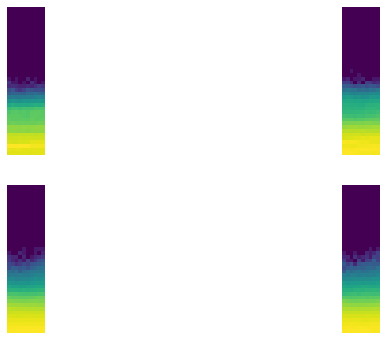

In [ ]:
trainer.ActivationStatsCB.color_dim()

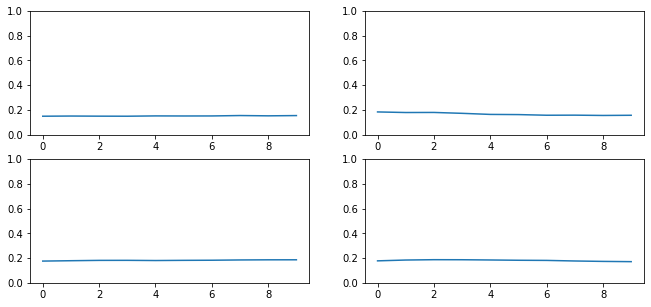

In [ ]:
trainer.ActivationStatsCB.dead_chart()

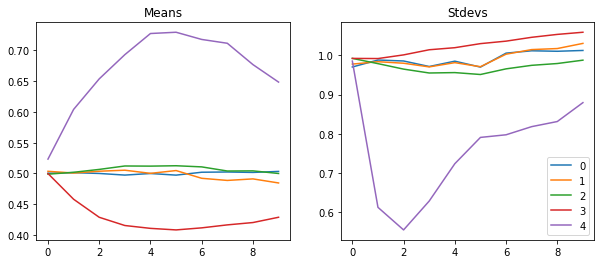

In [ ]:
trainer.ActivationStatsCB.plot_stats()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()